<a href="https://colab.research.google.com/github/neuroscout/neuroscout-cli/blob/colab/Neuroscout_CLI_Colab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Neuroscout on Google Colab

In [18]:
#@title 1) Set your Neuroscout Analysis ID { run: "auto" }

analysis_id = 'iarv7' #@param {type:"string"}

import os
os.environ['ANALYSIS_ID'] = analysis_id

print(f"Analysis ID set to: {analysis_id}")

Analysis ID set to: iarv7


In [17]:
#@title 2) Run to install Neuroscout-CLI & DataLad
%%capture --no-display
from IPython.display import display
display("Installing NeuroDebian...")

## Set up DataLad
!wget -O- http://neuro.debian.net/lists/bionic.us-tn.full | sudo tee /etc/apt/sources.list.d/neurodebian.sources.list && sudo apt-key adv --recv-keys --keyserver hkps://keyserver.ubuntu.com 0xA5D32F012649A5A9 && sudo apt-get update
display("Installing DataLad...")

!sudo apt-get install datalad -y
!git config --global user.email "you@example.com" && git config --global user.name "Your Name"

display("Installing Neuroscout...")
%pip install -e git+https://github.com/neuroscout/neuroscout-cli@fix/preproc_dir#egg=neuroscout-cli
display("Done.")


'Installing NeuroDebian...'

'Installing DataLad...'

'Installing Neuroscout...'

'Done.'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


### 3) Get Analysis Inputs

Using `neuroscout-cli`, we will first get the requisite data (processed fMRI inputs + analysis bundle), and configure the output folder.

`neuroscout-cli` uses [DataLad](https://www.datalad.org) under the hood to fetch the required data.

For more information on `neuroscout-cli` usage type: `!neuroscout --help` or see the [official documentation](https://neuroscout.github.io/neuroscout/cli/usage/).

In [ ]:
!neuroscout get --datalad-jobs=2 $analysis_id /out

## 4) Run your model

Now, we can use `neuroscout` to run our analysis.

`neuroscout` uses [FitLins](https://fitlins.readthedocs.io/en/latest/) under the hood to intepret your analysis' `BIDS Statistical Model`, and construct a workflow to fit the model. 

We can forward any valid `FitLins` arguments by passing them to `neuroscout`. For example, `--n-cpus=2` is forward to `FitLins` and sets the number of cores to use (Colab only has 2 cores available).

Since we've already fetched the data, we can also instruct `neuroscout` to not use DataLad to get the data (`--no-get`). Typically, `run` will automatically call `get` prior to execution, if you haven't already done so explicitly. 

In [ ]:
!neuroscout run --no-get --n-cpus=2 $analysis_id /out

INFO:root:Analysis ID : iarv7
IMPORTANT:cli:
Running FitLins version 0.10.1:
  * Participant list: None.

220428-00:08:09,361 nipype.workflow INFO:
	 [Node] Setting-up "fitlins_wf.loader" in "/tmp/tmpmogwx7ay/fitlins_wf/loader".
220428-00:08:09,367 nipype.workflow INFO:
	 [Node] Executing "loader" <fitlins.interfaces.bids.LoadBIDSModel>
/usr/local/lib/python3.7/dist-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/usr/local/lib/python3.7/dist-packages/bids/modeling/statsmodels.py:56: UserWarning: [Node run; Contrast speech]:Contrast 'Type' is now 'Test'.
  warnings.warn(f"[Node {node['name']}; Contrast {contrast['name']}]:"
220428-00:08:15,767 nipype.workflow INFO:
	 [Node] Finished "loader", elapsed time 6.398545s.
220428-00:08:21,375 nipype.workflow INFO:
	 [Node] Setting-up "f

### 5) Explore results

You can explore uploaded results on [neuroscout.org](https://neuroscout.org) by returning to the analysis builder page for your analysis.

Example: https://neuroscout.org/builder/iarv7

You can also view the local analysis outputs, stored in `/neuroscout-{analysis_id}` in this notebook.

In [ ]:
!ls /out/neuroscout-${analysis_id}/

fitlins  options.json  sourcedata


The output directory has two sub folders:
   - `fitlins`: contains the outputs of the model as executed by [FitLins](https://fitlins.readthedocs.io/en/latest/)
   - `sourcedata` includes all of the inputs required for execution, including the preprocessed dataset, and the contents of the Neuroscout analysis bundle (including Predictor events and the BIDS Stats Model JSON spec)

In [ ]:

!ls /out/neuroscout-${analysis_id}/fitlins

dataset_description.json
level-dataset_name-dataset_contrast-speech_stat-effect_statmap.nii.gz
level-dataset_name-dataset_contrast-speech_stat-p_statmap.nii.gz
level-dataset_name-dataset_contrast-speech_stat-t_statmap.nii.gz
level-dataset_name-dataset_contrast-speech_stat-variance_statmap.nii.gz
level-dataset_name-dataset_contrast-speech_stat-z_statmap.nii.gz
reports
sub-sid000005
sub-sid000007
sub-sid000009
sub-sid000010
sub-sid000013
sub-sid000020
sub-sid000021
sub-sid000024
sub-sid000025
sub-sid000029


Within the `fitlins` folder, we have `dataset` (i.e. group) level result images, HTML analysis `reports`, as well as subject level results.

For each contrast (in this instance there is only one: `speech`), we have maps of various statistics available. 

Let's take a look at a subject level `t` map for `speech`:

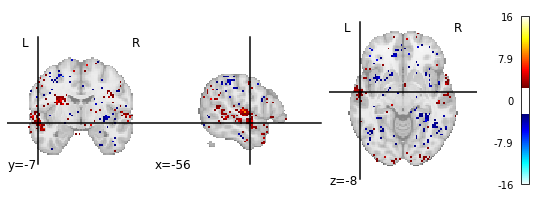

In [ ]:
from nilearn.plotting import plot_stat_map
from pathlib import Path

outputs = Path(f"/out/neuroscout-{analysis_id}/fitlins/")
statmaps = outputs.glob('level-dataset_*contrast*stat-t*.nii.gz')

for map in statmaps:
  plot_stat_map(str(map), title=map.basename threshold=2.58)

In our example analysis, `iarv7`, even with only 10 subjects (only first run), we see peak activity in the STS for speech, as expected.